In [ ]:
MNT_DRIVE_DIR = '/content/drive/'
DRIVE_DIR = '/content/drive/MyDrive/'
#DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/dataset'
FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES'

from google.colab import drive
drive.mount(MNT_DRIVE_DIR)

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)


In [ ]:
import numpy as np
np.random.seed(5)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import cifar10



In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


#Red Generativa

##Estructura de la red

In [ ]:
def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                              

##Prueba de funcionamiento

Para probar el funcionamiento de la red generativa ingresaremos unos datos de entrada aleatorios y generaremos imágenes a partir de ellos (seguramente serán ruido).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


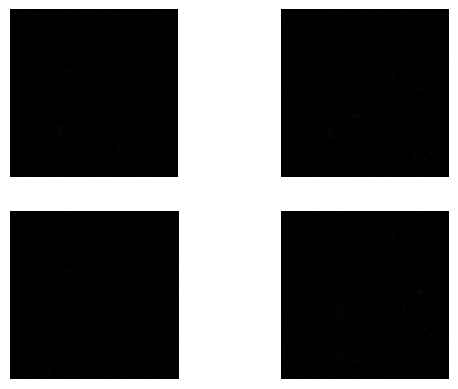

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input, verbose=0)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])


#Red Discriminadora

##Estructura de la red


In [ ]:
def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los aviones
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes().shape)


(5000, 32, 32, 3)


In [ ]:
#import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y


In [ ]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 Real:73.4375, Fake:0.0
2 Real:98.4375, Fake:3.125
3 Real:95.3125, Fake:9.375
4 Real:89.0625, Fake:32.8125
5 Real:93.75, Fake:75.0
6 Real:87.5, Fake:93.75
7 Real:84.375, Fake:100.0
8 Real:92.1875, Fake:100.0
9 Real:90.625, Fake:100.0
10 Real:95.3125, Fake:100.0
11 Real:92.1875, Fake:100.0
12 Real:92.1875, Fake:100.0
13 Real:90.625, Fake:100.0
14 Real:96.875, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:95.3125, Fake:100.0
17 Real:98.4375, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:98.4375, Fake:100.0
20 Real:100.0, Fake:100.0


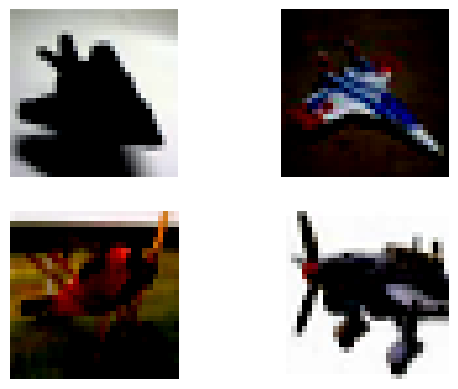

In [ ]:
dataset = cargar_imagenes()

# Visualizamos resultados
for i in range(4):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(dataset[i])


entrenar_discriminador(modelo_discriminador, dataset)

In [ ]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1007363   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()


In [ ]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # Guardamos el modelo
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # Generamos nuevos datos
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # Evaluamos el modelo
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real, verbose=0)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake, verbose=0)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')


In [ ]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # Iteramos para todos los epochs
  for epoch in range(inicio, inicio + epochs):
    # Iteramos para todos los batches
    for batch in range(n_batch):

      # Cargamos datos reales y entrenamos el discriminador con ellos
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
      # Enrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)


      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)
      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # Generamos datos de entadas de la GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # Entrenamos la GAN con datos falsos
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Cada 10 Epochs mostramos resultados y el coste
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)


In [ ]:
n_batch=128
dimension_batch = int(dataset.shape[0]/n_batch)
print(dimension_batch)

39


In [ ]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 100, n_batch=128, inicio = 0)

Acc Real:48.4375% Acc Fake:81.25%
Acc Real:62.5% Acc Fake:89.0625%
Acc Real:53.125% Acc Fake:87.5%
Acc Real:64.0625% Acc Fake:85.9375%
Acc Real:75.0% Acc Fake:92.1875%
Acc Real:59.375% Acc Fake:85.9375%
Acc Real:75.0% Acc Fake:92.1875%
Acc Real:75.0% Acc Fake:85.9375%
Acc Real:89.0625% Acc Fake:95.3125%
Acc Real:76.5625% Acc Fake:96.875%


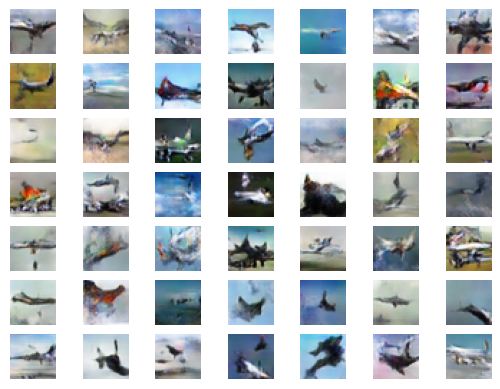

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])
